# Visualizing Movie Dataset Embeddings
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/togethercomputer/together-cookbook/blob/main/RAG_and_Search/Embedding_Visualization.ipynb)

### Introduction

In this notebook, we will be embedding a subset of the [Movies Dataset](https://www.kaggle.com/datasets/utkarshx27/movies-dataset) and visualizing the generated vector space representations of the movies using a technique called [Uniform Manifold Approximation and Projection (UMAP)](https://umap-learn.readthedocs.io/en/latest/index.html).

We will color code the movies using genres and see if similar movie genres cluster together in vector space and apart from movies of different movie genres.

<img src="../images/UMAP.png" width="500">

### Install relevant libraries

In [11]:
!pip install together
!pip install umap-learn[plot]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 70.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 6.5 MB/s eta 0:00:00


### Download and View the Dataset

In [ ]:
# Let's get the movies dataset
!wget https://raw.githubusercontent.com/togethercomputer/together-cookbook/refs/heads/main/datasets/movies.json
!mkdir datasets
!mv movies.json datasets/movies.json

In [2]:
import json

with open('../datasets/movies.json', 'r') as file:
    movies_data = json.load(file)

movies_data[:3]

[{'title': 'Minions',
  'overview': 'Minions Stuart, Kevin and Bob are recruited by Scarlet Overkill, a super-villain who, alongside her inventor husband Herb, hatches a plot to take over the world.',
  'director': 'Kyle Balda',
  'genres': 'Family Animation Adventure Comedy',
  'tagline': 'Before Gru, they had a history of bad bosses'},
 {'title': 'Interstellar',
  'overview': 'Interstellar chronicles the adventures of a group of explorers who make use of a newly discovered wormhole to surpass the limitations on human space travel and conquer the vast distances involved in an interstellar voyage.',
  'director': 'Christopher Nolan',
  'genres': 'Adventure Drama Science Fiction',
  'tagline': 'Mankind was born on Earth. It was never meant to die here.'},
 {'title': 'Deadpool',
  'overview': 'Deadpool tells the origin story of former Special Forces operative turned mercenary Wade Wilson, who after being subjected to a rogue experiment that leaves him with accelerated healing powers, ado

We've got popular movie titles along with information about their genres, plot overviews and more.

### Generate Embeddings

We will use the Together AI embedding API to generate vector representations for each movie title + overview + tagline.

In [3]:
import os

# Paste in your Together AI API Key or load it
TOGETHER_API_KEY = os.environ.get("TOGETHER_API_KEY")

In [8]:
from typing import List
import together
import numpy as np

def generate_embeddings(input_texts: List[str], model_api_string: str) -> List[List[float]]:
    """Generate embeddings from Together python library.

    Args:
        input_texts: a list of string input texts.
        model_api_string: str. An API string for a specific embedding model of your choice.

    Returns:
        embeddings_list: a list of embeddings. Each element corresponds to the each input text.
    """
    together_client = together.Together(api_key = TOGETHER_API_KEY)
    outputs = together_client.embeddings.create(
        input=input_texts,
        model=model_api_string,
    )
    return [x.embedding for x in outputs.data]

In [5]:
# Concatenate the title, overview, and tagline of each movie
# this makes the text that will be embedded for each movie more informative
# as a result the embeddings will be richer and capture this information. 
to_embed = []
for movie in movies_data[:1000]:
    text = ''
    for field in ['title', 'overview', 'tagline']:
        value = movie.get(field, '')
        text += str(value) + ' '
    to_embed.append(text.strip())

to_embed[:10]

['Minions Minions Stuart, Kevin and Bob are recruited by Scarlet Overkill, a super-villain who, alongside her inventor husband Herb, hatches a plot to take over the world. Before Gru, they had a history of bad bosses',
 'Interstellar Interstellar chronicles the adventures of a group of explorers who make use of a newly discovered wormhole to surpass the limitations on human space travel and conquer the vast distances involved in an interstellar voyage. Mankind was born on Earth. It was never meant to die here.',
 'Deadpool Deadpool tells the origin story of former Special Forces operative turned mercenary Wade Wilson, who after being subjected to a rogue experiment that leaves him with accelerated healing powers, adopts the alter ego Deadpool. Armed with his new abilities and a dark, twisted sense of humor, Deadpool hunts down the man who nearly destroyed his life. Witness the beginning of a happy ending',
 'Guardians of the Galaxy Light years from Earth, 26 years after being abducted,

In [6]:
# We will use the bge-base-en-v1.5 model to generate embeddings for the movies
embeddings = generate_embeddings(to_embed, 'BAAI/bge-base-en-v1.5')

In [9]:
# Verify that we get 1000 vectors of 768 dimensions each
embeddings_np = np.array(embeddings)

embeddings_np.shape

(1000, 768)

In [38]:
# Extract the genres and titles for each movie
genres = [movie['genres'].split()[0] for movie in movies_data]
titles = [movie['title'] for movie in movies_data]
set(genres)

{'Action',
 'Adventure',
 'Animation',
 'Comedy',
 'Crime',
 'Drama',
 'Family',
 'Fantasy',
 'History',
 'Horror',
 'Music',
 'Mystery',
 'Romance',
 'Science',
 'Thriller',
 'War',
 'Western'}

### Visualize Embeddings using UMAP

UMAP is a technique that uses local structure of the high dimensional vectors to reduce them down to a very low dimensional space. In our case below we will be projecting each 768 dimensional vector down to 2 dimensions and then visualizing it.

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


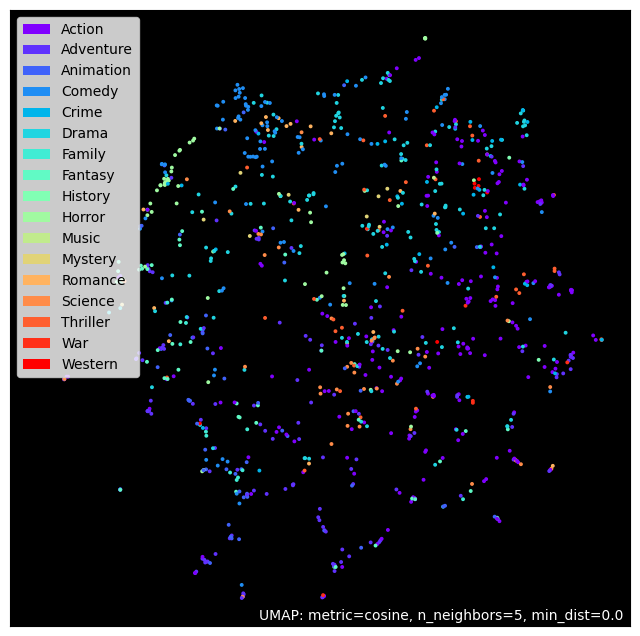

In [37]:
import umap, umap.plot
import matplotlib.pyplot as plt

# UMAP with cosine metric - this is because the embeddings model is trained using cosine similarity
mapper = umap.UMAP(n_neighbors=5, min_dist=0.0, metric='cosine', random_state=42).fit(embeddings)

# Plot the 2d UMAP embeddings and color by genre
umap.plot.points(mapper, labels = np.array(genres), theme='fire');

Here we can see that there is some clustering with respect to the movie genres, however there is not a clear pattern - this is probably because the genres for each movie can overlap and each movie actually has multiple genres.

Learn more about how to use embedding models in the [docs](https://docs.together.ai/docs/embeddings-overview) here!